In [116]:
import pickle, tensorflow as tf, numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Embedding,
    SpatialDropout1D,
    Bidirectional,
    LSTM,
    TimeDistributed,
    Dense,
)
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from collections import Counter
from itertools import zip_longest

In [117]:
data = []
with open("../dataset/new_ner_srl.tsv", encoding="utf-8") as f:
# with open("../dataset/test_ns_dataset.tsv", encoding="utf-8") as f:
    tok, ner, srl = [], [], []
    for line in f:
        line = line.strip()
        if not line:
            if tok:
                data.append({"tokens": tok, "labels_ner": ner, "labels_srl": srl})
                tok, ner, srl = [], [], []
        else:
            t, n, s = line.split("\t")
            tok.append(t.lower())
            ner.append(n.strip())
            srl.append(s.strip())

print("total kalimat ", len(data))
# ——————————————————
sentences = [d["tokens"] for d in data]
labels_ner = [d["labels_ner"] for d in data]
labels_srl = [d["labels_srl"] for d in data]

ner_counter = Counter(label for seq in labels_ner for label in seq)

srl_counter = Counter(label for seq in labels_srl for label in seq)


print(f"{'NER Label':<15} {'Count':<10} || {'SRL Label':<15} {'Count':<10}")
print("-" * 55)

for (ner_label, ner_count), (srl_label, srl_count) in zip_longest(ner_counter.items(), srl_counter.items(), fillvalue=('', '')):
    print(f"{ner_label:<15} {ner_count:<10} || {srl_label:<15} {srl_count:<10}")

total kalimat  1639
NER Label       Count      || SRL Label       Count     
-------------------------------------------------------
O               7261       || O               4182      
B-TIME          189        || ARGM-TMP        1292      
B-PER           1313       || ARG0            1965      
B-LOC           1554       || V               1738      
I-PER           226        || ARG1            1308      
B-DATE          339        || ARGM-LOC        1503      
I-DATE          647        || ARG2            293       
B-ETH           213        || ARGM-MOD        39        
I-ETH           217        || ARGM-MNR        37        
B-EVENT         70         || ARGM-NEG        6         
I-EVENT         55         || ARGM-DIR        41        
I-LOC           32         || ARGM-CAU        21        
B-MISC          14         ||                           
I-MISC          3          ||                           
I-TIME          46         ||                           
B-ORG       

In [118]:


def calculate_o_percentage(labels):
    counter = Counter(label for seq in labels for label in seq)
    total = sum(counter.values())
    count_o = counter.get("O", 0)
    percent_o = (count_o / total) * 100 if total > 0 else 0
    return percent_o, total, count_o

# Hitung persentase 'O' untuk NER
o_ner_percent, total_ner, o_ner_count = calculate_o_percentage(labels_ner)

# Hitung persentase 'O' untuk SRL
o_srl_percent, total_srl, o_srl_count = calculate_o_percentage(labels_srl)

print(f"NER  -> Total Labels: {total_ner}, O Count: {o_ner_count}, O Percentage: {o_ner_percent:.2f}%")
print(f"SRL  -> Total Labels: {total_srl}, O Count: {o_srl_count}, O Percentage: {o_srl_percent:.2f}%")


NER  -> Total Labels: 12425, O Count: 7261, O Percentage: 58.44%
SRL  -> Total Labels: 12425, O Count: 4182, O Percentage: 33.66%


In [119]:
PAD_TOKEN = "<PAD>"
words = sorted({w for s in sentences for w in s})

ner_tags = sorted({t for seq in labels_ner for t in seq})
srl_tags = sorted({t for seq in labels_srl for t in seq})

ner_tags.insert(0, PAD_TOKEN)
srl_tags.insert(0, PAD_TOKEN)

word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["PAD"] = 0
word2idx["UNK"] = 1

tag2idx_ner = {t: i for i, t in enumerate(ner_tags)}
tag2idx_srl = {t: i for i, t in enumerate(srl_tags)}
idx2tag_ner = {i: t for t, i in tag2idx_ner.items()}
idx2tag_srl = {i: t for t, i in tag2idx_srl.items()}

In [120]:
X = [[word2idx.get(w, 1) for w in s] for s in sentences]
y_ner = [[tag2idx_ner[t] for t in seq] for seq in labels_ner]
y_srl = [[tag2idx_srl[t] for t in seq] for seq in labels_srl]

maxlen = max(map(len, X))
pad_id = tag2idx_ner[PAD_TOKEN]

X = pad_sequences(X, maxlen=maxlen, padding="post", value=0)
y_ner = pad_sequences(y_ner, maxlen=maxlen, padding="post", value=pad_id)
y_srl = pad_sequences(y_srl, maxlen=maxlen, padding="post", value=pad_id)

mask = (y_ner != pad_id).astype("float32")

In [121]:
splits = train_test_split(
    X, y_ner, y_srl, mask, test_size=0.2, random_state=42, shuffle=True
)
X_tr, X_te, ner_tr, ner_te, srl_tr, srl_te, m_tr, m_te = splits

In [122]:
embed_dim = 64
lstm_units = 64
drop_embed = 0.5
drop_lstm = 0.5

inp = Input(shape=(maxlen,), name="tokens")
emb = Embedding(len(word2idx), embed_dim, mask_zero=True, name="embed")(inp)
emb = SpatialDropout1D(drop_embed)(emb)

x = Bidirectional(
    LSTM(
        lstm_units,
        return_sequences=True,
        dropout=drop_lstm,
        recurrent_dropout=drop_lstm,
    )
)(emb)
x = Bidirectional(
    LSTM(
        lstm_units,
        return_sequences=True,
        dropout=drop_lstm,
        recurrent_dropout=drop_lstm,
    )
)(x)

ner_head = TimeDistributed(Dense(lstm_units, activation="relu"))(x)
ner_out = TimeDistributed(
    Dense(len(tag2idx_ner), activation="softmax"), name="ner_output"
)(ner_head)

srl_head = TimeDistributed(Dense(lstm_units, activation="relu"))(x)
srl_out = TimeDistributed(
    Dense(len(tag2idx_srl), activation="softmax"), name="srl_output"
)(srl_head)

model = Model(inp, [ner_out, srl_out])

model.compile(
    optimizer=tf.keras.optimizers.Adam(3e-4),
    loss={
        "ner_output": "sparse_categorical_crossentropy",
        "srl_output": "sparse_categorical_crossentropy",
    },
    metrics={
        "ner_output": ["sparse_categorical_accuracy"],
        "srl_output": ["sparse_categorical_accuracy"],
    },
    # sample_weight_mode="temporal"
)
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ tokens (InputLayer) │ (None, 34)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embed (Embedding)   │ (None, 34, 64)    │     87,296 │ tokens[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_7 │ (None, 34, 64)    │          0 │ embed[0][0]       │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_7         │ (None, 34)        │          0 │ tokens[0][0]      │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_14    │ (None, 34, 128)   │     66,048 │ spatial_dropout1… │
│ (Bidirectional)     │                   │            │ not_equal_7[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_15    │ (None, 34, 128)   │     98,816 │ bidirectional_14… │
│ (Bidirectional)     │                   │            │ not_equal_7[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_14 │ (None, 34, 64)    │      8,256 │ bidirectional_15… │
│ (TimeDistributed)   │                   │            │ not_equal_7[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_15 │ (None, 34, 64)    │      8,256 │ bidirectional_15… │
│ (TimeDistributed)   │                   │            │ not_equal_7[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ner_output          │ (None, 34, 24)    │      1,560 │ time_distributed… │
│ (TimeDistributed)   │                   │            │ not_equal_7[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ srl_output          │ (None, 34, 13)    │        845 │ time_distributed… │
│ (TimeDistributed)   │                   │            │ not_equal_7[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 271,077 (1.03 MB)

 Trainable params: 271,077 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

In [123]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-5),
]

history = model.fit(
    X_tr,
    [ner_tr, srl_tr],  # y → LIST (pos 0 = ner_output, 1 = srl_output)
    sample_weight=[m_tr, m_tr],  # sama‑persis urutan
    validation_data=(X_te, [ner_te, srl_te], [m_te, m_te]),
    
    batch_size=64,
    epochs=30,
    callbacks=callbacks,
    verbose=1,
)


# =========================
# 7.  Save artefacts
# =========================
model.save("lstm_ner_srl_model.keras")
for fname, obj in [
    ("word2idx.pkl", word2idx),
    ("tag2idx_ner.pkl", tag2idx_ner),
    ("tag2idx_srl.pkl", tag2idx_srl),
]:
    with open(fname, "wb") as f:
        pickle.dump(obj, f)

Epoch 1/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 5.7110 - ner_output_loss: 3.1579 - ner_output_sparse_categorical_accuracy: 0.2067 - srl_output_loss: 2.5530 - srl_output_sparse_categorical_accuracy: 0.1810 - val_loss: 5.5840 - val_ner_output_loss: 3.0747 - val_ner_output_sparse_categorical_accuracy: 0.1325 - val_srl_output_loss: 2.5086 - val_srl_output_sparse_categorical_accuracy: 0.0750 - learning_rate: 3.0000e-04
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 5.4576 - ner_output_loss: 2.9911 - ner_output_sparse_categorical_accuracy: 0.1311 - srl_output_loss: 2.4653 - srl_output_sparse_categorical_accuracy: 0.0760 - val_loss: 4.6826 - val_ner_output_loss: 2.4715 - val_ner_output_sparse_categorical_accuracy: 0.1325 - val_srl_output_loss: 2.1957 - val_srl_output_sparse_categorical_accuracy: 0.0750 - learning_rate: 3.0000e-04
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 4.3203 - ner_output_loss: 2.2263 - ner_output_sparse_categorical_accuracy: 0.1270

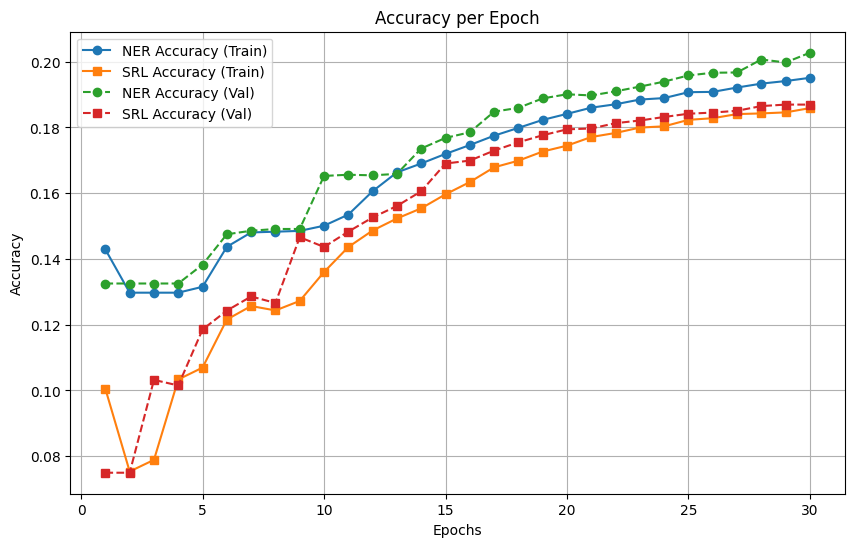

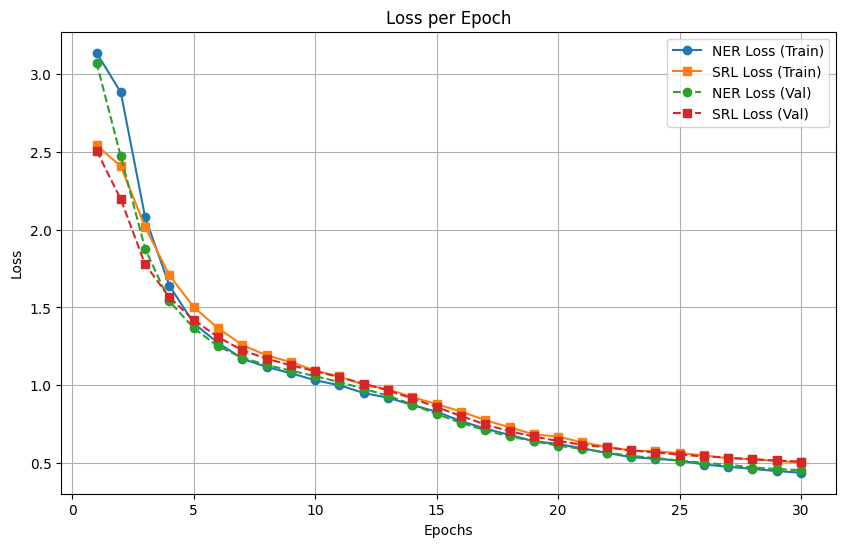

In [124]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    history_data = history.history
    epochs = range(1, len(next(iter(history_data.values()))) + 1)

    # Coba deteksi metric secara dinamis agar fleksibel
    ner_acc_key = next((k for k in history_data if "ner_output" in k and "accuracy" in k), None)
    srl_acc_key = next((k for k in history_data if "srl_output" in k and "accuracy" in k), None)
    val_ner_acc_key = f"val_{ner_acc_key}" if ner_acc_key else None
    val_srl_acc_key = f"val_{srl_acc_key}" if srl_acc_key else None

    # --- Plot Accuracy ---
    plt.figure(figsize=(10, 6))
    if ner_acc_key:
        plt.plot(epochs, history_data[ner_acc_key], marker="o", label="NER Accuracy (Train)")
    if srl_acc_key:
        plt.plot(epochs, history_data[srl_acc_key], marker="s", label="SRL Accuracy (Train)")
    if val_ner_acc_key in history_data:
        plt.plot(epochs, history_data[val_ner_acc_key], marker="o", linestyle="--", label="NER Accuracy (Val)")
    if val_srl_acc_key in history_data:
        plt.plot(epochs, history_data[val_srl_acc_key], marker="s", linestyle="--", label="SRL Accuracy (Val)")

    plt.title("Accuracy per Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.savefig("accuracy_plot.png")
    plt.show()

    # --- Plot Loss ---
    plt.figure(figsize=(10, 6))
    if "ner_output_loss" in history_data:
        plt.plot(epochs, history_data["ner_output_loss"], marker="o", label="NER Loss (Train)")
    if "srl_output_loss" in history_data:
        plt.plot(epochs, history_data["srl_output_loss"], marker="s", label="SRL Loss (Train)")
    if "val_ner_output_loss" in history_data:
        plt.plot(epochs, history_data["val_ner_output_loss"], marker="o", linestyle="--", label="NER Loss (Val)")
    if "val_srl_output_loss" in history_data:
        plt.plot(epochs, history_data["val_srl_output_loss"], marker="s", linestyle="--", label="SRL Loss (Val)")

    plt.title("Loss per Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.savefig("loss_plot.png")
    plt.show()


plot_training_history(history)

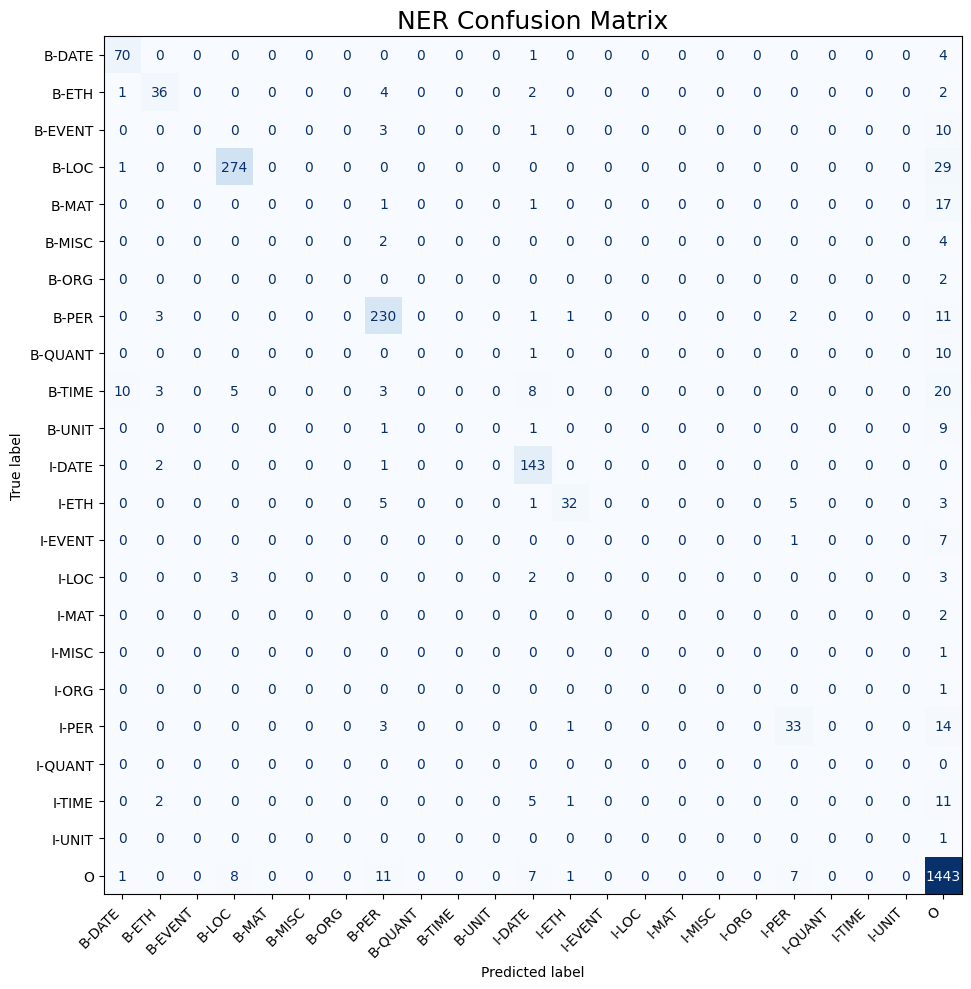

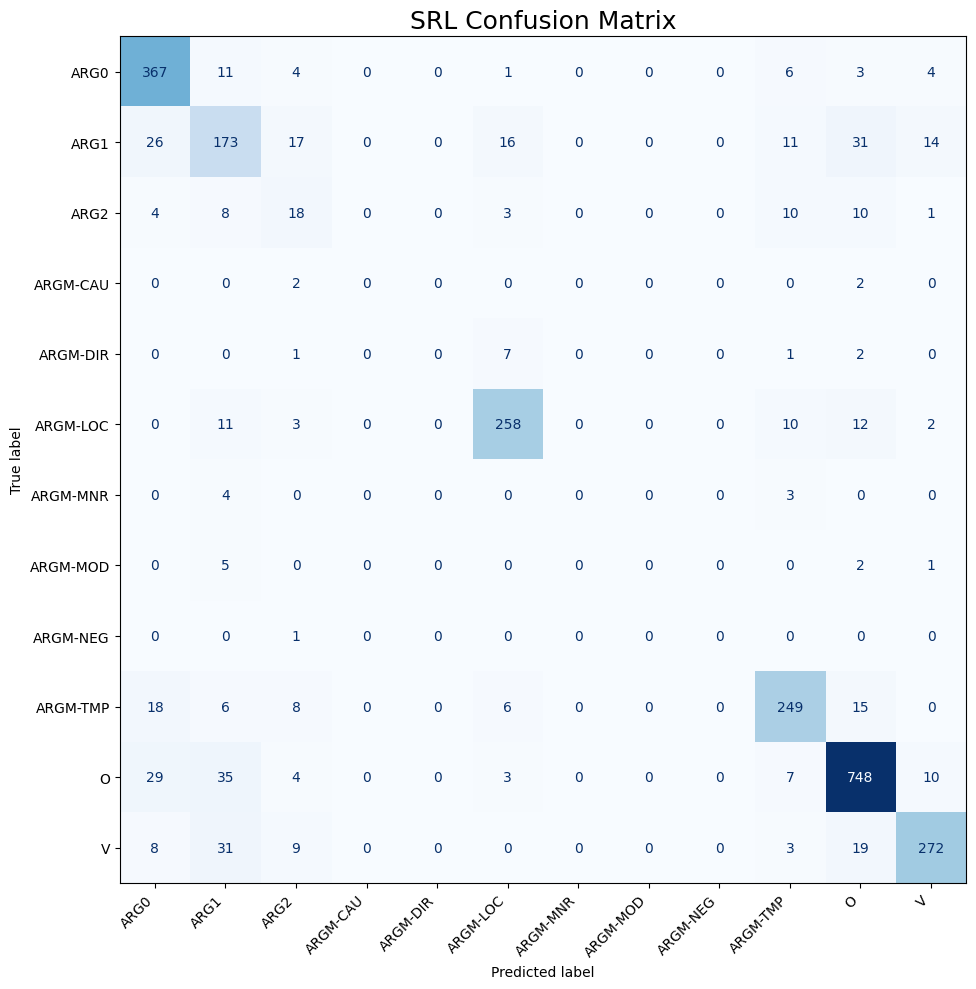

In [125]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ------------------------------------------------------------------
# 1.  Prediksi
# ------------------------------------------------------------------
pred_ner_prob, pred_srl_prob = model.predict(X_te, verbose=0)

pred_ner = pred_ner_prob.argmax(-1)
pred_srl = pred_srl_prob.argmax(-1)

# ------------------------------------------------------------------
# 2.  Siapkan masker PAD
# ------------------------------------------------------------------
pad_id = tag2idx_ner["<PAD>"]

mask_ner = ner_te != pad_id
mask_srl = srl_te != pad_id

true_ner_flat = ner_te[mask_ner]
pred_ner_flat = pred_ner[mask_ner]

true_srl_flat = srl_te[mask_srl]
pred_srl_flat = pred_srl[mask_srl]

# ------------------------------------------------------------------
# 3.  Hitung confusion matrix TANPA PAD
# ------------------------------------------------------------------
# Buang ID PAD dari label list
labels_ner_no_pad = [i for i in range(len(tag2idx_ner)) if i != pad_id]
labels_srl_no_pad = [i for i in range(len(tag2idx_srl)) if i != pad_id]

cm_ner = confusion_matrix(true_ner_flat, pred_ner_flat, labels=labels_ner_no_pad)

cm_srl = confusion_matrix(true_srl_flat, pred_srl_flat, labels=labels_srl_no_pad)

# Siapkan label display TANPA PAD
display_labels_ner = [idx2tag_ner[i] for i in labels_ner_no_pad]
display_labels_srl = [idx2tag_srl[i] for i in labels_srl_no_pad]

# ------------------------------------------------------------------
# 4.  Plot NER CM (tanpa PAD)
# ------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 10))
disp_ner = ConfusionMatrixDisplay(
    confusion_matrix=cm_ner, display_labels=display_labels_ner
)
disp_ner.plot(
    include_values=True,  # Tampilkan angka
    values_format="d",  # Format integer
    cmap=plt.cm.Blues,  # Biru-putih
    ax=ax,
    colorbar=False,
)
ax.set_title("NER Confusion Matrix", fontsize=18)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# 5.  Plot SRL CM (tanpa PAD)
# ------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 10))
disp_srl = ConfusionMatrixDisplay(
    confusion_matrix=cm_srl, display_labels=display_labels_srl
)
disp_srl.plot(
    include_values=True, values_format="d", cmap=plt.cm.Blues, ax=ax, colorbar=False
)
ax.set_title("SRL Confusion Matrix", fontsize=18)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [126]:
from sklearn.metrics import accuracy_score, classification_report

# ------------------------------------------------------------------
# 3b.  Akurasi token‑level (tanpa PAD)
# ------------------------------------------------------------------
acc_ner = accuracy_score(true_ner_flat, pred_ner_flat)
acc_srl = accuracy_score(true_srl_flat, pred_srl_flat)

print(f"NER TAG accuracy : {acc_ner:.2%}")
print(f"SRL TAG accuracy : {acc_srl:.2%}")

NER TAG accuracy : 88.84%
SRL TAG accuracy : 81.93%


In [127]:
# (Opsional) tampilkan ringkasan metrik per‑label
print("\n[NER] Classification report:")
print(
    classification_report(
        true_ner_flat,
        pred_ner_flat,
        labels=labels_ner_no_pad,
        target_names=display_labels_ner,
        digits=2,
    )
)


[NER] Classification report:
              precision    recall  f1-score   support

      B-DATE       0.84      0.93      0.89        75
       B-ETH       0.78      0.80      0.79        45
     B-EVENT       0.00      0.00      0.00        14
       B-LOC       0.94      0.90      0.92       304
       B-MAT       0.00      0.00      0.00        19
      B-MISC       0.00      0.00      0.00         6
       B-ORG       0.00      0.00      0.00         2
       B-PER       0.87      0.93      0.90       248
     B-QUANT       0.00      0.00      0.00        11
      B-TIME       0.00      0.00      0.00        49
      B-UNIT       0.00      0.00      0.00        11
      I-DATE       0.82      0.98      0.89       146
       I-ETH       0.89      0.70      0.78        46
     I-EVENT       0.00      0.00      0.00         8
       I-LOC       0.00      0.00      0.00         8
       I-MAT       0.00      0.00      0.00         2
      I-MISC       0.00      0.00      0.00        

/mnt/disc1/code/thesis_quiz_project/lstm-quiz/myenv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/disc1/code/thesis_quiz_project/lstm-quiz/myenv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/disc1/code/thesis_quiz_project/lstm-quiz/myenv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this beha

In [128]:
print("\n[SRL] Classification report:")
print(
    classification_report(
        true_srl_flat,
        pred_srl_flat,
        labels=labels_srl_no_pad,
        target_names=display_labels_srl,
        digits=2,
    )
)


[SRL] Classification report:
              precision    recall  f1-score   support

        ARG0       0.81      0.93      0.87       396
        ARG1       0.61      0.60      0.60       288
        ARG2       0.27      0.33      0.30        54
    ARGM-CAU       0.00      0.00      0.00         4
    ARGM-DIR       0.00      0.00      0.00        11
    ARGM-LOC       0.88      0.87      0.87       296
    ARGM-MNR       0.00      0.00      0.00         7
    ARGM-MOD       0.00      0.00      0.00         8
    ARGM-NEG       0.00      0.00      0.00         1
    ARGM-TMP       0.83      0.82      0.83       302
           O       0.89      0.89      0.89       836
           V       0.89      0.80      0.84       342

    accuracy                           0.82      2545
   macro avg       0.43      0.44      0.43      2545
weighted avg       0.81      0.82      0.82      2545



/mnt/disc1/code/thesis_quiz_project/lstm-quiz/myenv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/disc1/code/thesis_quiz_project/lstm-quiz/myenv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/disc1/code/thesis_quiz_project/lstm-quiz/myenv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

In [129]:
# def plot_training_history(history):
#     epochs = range(1, len(history['loss']) + 1)

#     plt.figure(figsize=(14, 6))

#     # Plot Loss
#     plt.subplot(1, 2, 1)
#     plt.plot(epochs, history['loss'], label='Training Loss')
#     plt.plot(epochs, history['val_loss'], label='Validation Loss')
#     plt.title('Loss During Training')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.legend()

#     # Plot Accuracy
#     plt.subplot(1, 2, 2)
#     plt.plot(epochs, history['ner_output_accuracy'], label='NER Train Acc')
#     plt.plot(epochs, history['val_ner_output_accuracy'], label='NER Val Acc')
#     plt.plot(epochs, history['srl_output_accuracy'], label='SRL Train Acc')
#     plt.plot(epochs, history['val_srl_output_accuracy'], label='SRL Val Acc')
#     plt.title('Accuracy During Training')
#     plt.xlabel('Epochs')
#     plt.ylabel('Accuracy')
#     plt.legend()

#     plt.tight_layout()
#     plt.show()

# plot_training_history(history.history)

In [130]:
# def token_level_accuracy(y_true, y_pred):
#     total, correct = 0, 0
#     for true_seq, pred_seq in zip(y_true, y_pred):
#         for t, p in zip(true_seq, pred_seq):
#             if t.sum() == 0:
#                 continue
#             total += 1
#             if t.argmax() == p.argmax():
#                 correct += 1
#     return correct / total

# def decode_predictions(pred, true, idx2tag):
#     true_out, pred_out = [], []
#     for pred_seq, true_seq in zip(pred, true):
#         t_labels, p_labels = [], []
#         for p_tok, t_tok in zip(pred_seq, true_seq):
#             if t_tok.sum() == 0:
#                 continue
#             t_labels.append(idx2tag[t_tok.argmax()])
#             p_labels.append(idx2tag[p_tok.argmax()])
#         true_out.append(t_labels)
#         pred_out.append(p_labels)
#     return true_out, pred_out

# results = model.evaluate(X_test, {"ner_output": y_ner_test, "srl_output": y_srl_test}, verbose=0)
# for name, value in zip(model.metrics_names, results):
#     print(f"{name}: {value}")

# y_pred_ner, y_pred_srl = model.predict(X_test, verbose=0)

# true_ner, pred_ner = decode_predictions(y_pred_ner, y_ner_test, idx2tag_ner)
# true_srl, pred_srl = decode_predictions(y_pred_srl, y_srl_test, idx2tag_srl)

# acc_ner = token_level_accuracy(y_ner_test, y_pred_ner)
# acc_srl = token_level_accuracy(y_srl_test, y_pred_srl)

# print(f"NER Token Accuracy {acc_ner:.2%}")
# print(f"SRL Token Accuracy {acc_srl:.2%}")

In [131]:
# print("[NER] Classification Report:")
# print(classification_report(true_ner, pred_ner, digits=2))

In [132]:
# print("SRL Classification Resport:")
# print(classification_report(true_srl, pred_srl, digits=2))